In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# x1   IO3-
# x2   I-
# x3   I2
# x4   HOIO
# x5   HOI
# x6   IO2
# x7   MnOH2+
# x8   HOO
# x9   MA
# x10  H2O2
# x11  O2     # Concentration as if it stayed in the solution
# x10  H2O    # Algebric concentration of water from the reaction system

# Dictionary of chemical species names
species_names = {
    0: "IO3-",
    1: "I-",
    2: "I2",
    3: "HOIO",
    4: "HOI",
    5: "IO2",
    6: "MnOH2+",
    7: "HOO",
    8: "MA",
    9: "H2O2",
    10: "O2",
    11: "H2O var"
}

# 1) 2H+ + I- + IO3- = HOI + HOIO         k1 = 1.43 x 10^3 M-3 s-1
# 2) H+ + HOIO + I- = 2HOI                k2 = 2.0 x 10^10 M-2 s-1
# 3) HOI + I- + H+ = I2 + H2O             k3 = 3.1 x 10^12 M-2 s-1 and k-3 = 2.2 s-1
# 4) HOIO + IO3- + H+ = 2IO2 + H2O        k4 = 7.3 x 10^3 M-2 s-1 and k-4 = 1.7 x 10^7 M-1 s-1
# 5) 2HOIO = HOI + I03- + H+              k5 = 6 x 10^5 M-1 s-1
# 6) IO2 + Mn2+ + H2O = HOIO + MnOH2+     k6 = 1.0 x 10^4 M-1 s-1
# 7) H2O2 + MnOH2+ = HOO + Mn2+ + H2O     k7 = 3.2 x 10^4 M-1 s-1
# 8) 2HOO = H2O2 + O2                     k8 = 7.5 x 10^5 M-1 s-1
# 9) I2 + MA = IMA + I- + H+              k9 = 40 M-1 s-1, C9 = 10^4 M-1
# 10) HOI + H2O2 = I- + O2 + H+ + H2O     k10 = 37 M-1 s-1

# Dictionary of chemical reactions
# Algebric display of reversible reactions vtotal = v - vrev
reaction_names = {
    0: "2H+ + I- + IO3- = HOI + HOIO",
    1: "H+ + HOIO + I- = 2HOI",
    2: "HOI + I- + H+ = I2 + H2O",
    3: "HOIO + IO3- + H+ = 2IO2 + H2O",
    4: "2HOIO = HOI + IO3- + H+",
    5: "IO2 + Mn2+ + H2O = HOIO + MnOH2+",
    6: "H2O2 + MnOH2+ = HOO + Mn2+ + H2O",
    7: "2HOO = H2O2 + O2",
    8: "I2 + MA = IMA + I- + H+",
    9: "HOI + H2O2 = I- + O2 + H+ + H2O"
}

# Concentration assumptions
K_h = 0.035  # h+ concentration considered constant
K_A = 0.005  # Total concentration of Mn under any form

# Reaction constants
K_k1 = 1.43e3
K_k2 = 2e10
K_k3 = 3.1e12
K_k3r = 2.2 # r3 reversed
K_k4 = 7.3e3
K_k4r = 1.7e7 # r4 reversed
K_k5 = 6e5
K_k6 = 1e4
K_k7 = 3.2e4
K_k8 = 7.5e5
K_k9 = 40.0
K_C9 = 1e4 # r9 second parameter
K_k10 = 37.0
    
def system(t, z):
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12 = z
    v1 = K_k1 * K_h**2 * x2 * x1
    v2 = K_k2 * K_h * x4 * x2
    v3 = K_k3 * K_h * x5 * x2
    v3r = K_k3r * x3
    v4 = K_k4 * K_h * x1 * x4
    v4r = K_k4r * x6**2
    v5 = K_k5 * x4**2
    v6 = K_k6 * x6 * (K_A - x7)
    v7 = K_k7 * x7 * x10
    v8 = K_k8 * x8**2
    v9 = K_k9 * x9 * x3 / (1.0 + K_C9 * x3)
    v10 = K_k10 * x10 * x5
    dx1dt = v4r + v5 - v1 - v4
    dx2dt = v3r + v9 + v10 - v1 - v2 - v3
    dx3dt = v3 - v3r - v9
    dx4dt = v1 + v4r + v6 - v2 - v4 - 2.0 * v5
    dx5dt = v1 + 2.0 * v2 + v3r + v5 - v3 - v10
    dx6dt = 2.0 * v4 - 2.0 * v4r - v6
    dx7dt = v6 - v7
    dx8dt = v7 - 2.0 * v8
    dx9dt = -v9
    dx10dt = v8 - v7 - v10
    dx11dt = v8 + v10
    dx12dt = v3 + v4 + v7 + v10 - v6
    return [dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt, dx8dt, dx9dt, dx10dt, dx11dt, dx12dt]

In [3]:
# Conditions initiales
z0 = [0.05, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.038, 0.88, 0.01, 0.01]

# Intervalle de temps sur lequel résoudre le système
t_span = (0, 2000)

# Points où résoudre la solution
t_eval = np.linspace(t_span[0], t_span[1], 20000)

# Résolution du système #BDF method seems more stable but throws an exception at first run
sol = solve_ivp(system, t_span, z0, method='LSODA', t_eval=t_eval, atol=1e-13, rtol=1e-10)
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01 ...  2.000e+03  2.000e+03]
        y: [[ 5.000e-02  5.619e-02 ...  4.380e-02  4.380e-02]
            [ 5.000e-03  2.457e-08 ...  3.354e-08  3.345e-08]
            ...
            [ 1.000e-02  1.700e-02 ...  2.990e-02  2.990e-02]
            [ 1.000e-02  2.653e-02 ...  4.020e+00  4.020e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 30483
     njev: 1265
      nlu: 1265


In [4]:
def normalize_curves(curves):
    normalized_y = np.zeros_like(curves)  # Create an array of the same shape as the solution for storing normalized data
    for i in range(curves.shape[0]):  # Loop through each variable (row) in the solution
        min_val = np.min(curves[i])
        max_val = np.max(curves[i])
        if min_val == max_val:
            normalized_y[i] = curves[i] - min_val  # Adjusts the constant curve to zero
        else:
            normalized_y[i] = (curves[i] - min_val) / (max_val - min_val)  # Affine normalization
    return normalized_y
   
def apply_log10_to_curves(curves):
    log10_curves = np.zeros_like(curves)
    for i in range(curves.shape[0]):
        # Apply log10, ensuring no log(0) issue; adding a small number to avoid log(0)
        log10_curves[i] = np.log10(curves[i] + 1e-7)  # 1e-7 to avoid log artefact at 0
    return log10_curves
   
concentration_curves = sol.y

# Compute reaction speed curves based on concentration curves
x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12 = concentration_curves
v1 = K_k1 * K_h**2 * x2 * x1
v2 = K_k2 * K_h * x4 * x2
v3 = K_k3 * K_h * x5 * x2
v3r = K_k3r * x3
v4 = K_k4 * K_h * x1 * x4
v4r = K_k4r * x6**2
v5 = K_k5 * x4**2
v6 = K_k6 * x6 * (K_A - x7)
v7 = K_k7 * x7 * x10
v8 = K_k8 * x8**2
v9 = K_k9 * x9 * x3 / (1.0 + K_C9 * x3)
v10 = K_k10 * x10 * x5
reaction_speed_curves = np.array([v1, v2, v3-v3r, v4-v4r, v5, v6, v7, v8, v9, v10])
# To see synchros:
# reaction_speed_curves = np.array([v1, v2, (v3-v3r)/3.0, 2.0*(v4-v4r), 4.0*v5, v6, v7, 2.0*v8, v9, v10])

# Modification for display
concentration_curves = apply_log10_to_curves(concentration_curves)
concentration_curves = normalize_curves(concentration_curves)
# reaction_speed_curves = apply_log10_to_curves(reaction_speed_curves)
# reaction_speed_curves = normalize_curves(reaction_speed_curves)

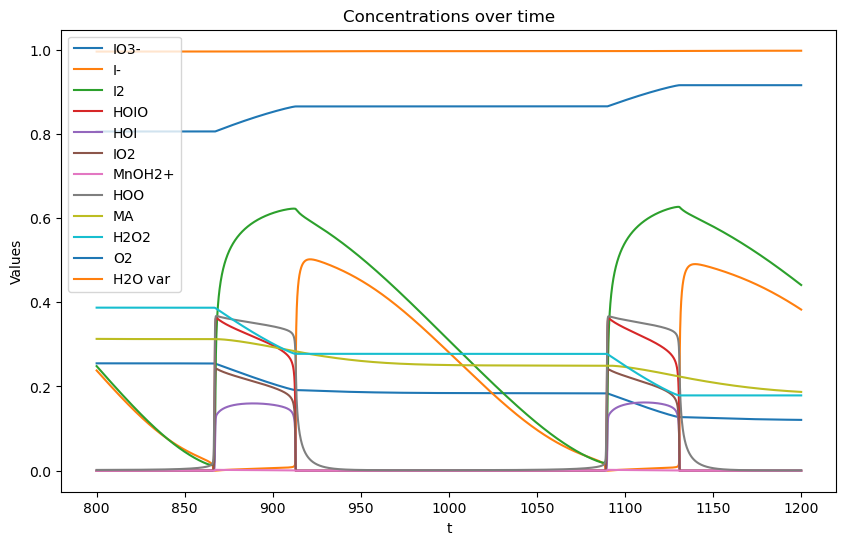

In [5]:
# Create checkboxes for each curve
chemical_checkboxes = [widgets.Checkbox(value=True, description=species_names[i]) for i in range(concentration_curves.shape[0])]
c_button = widgets.Button(description="Plot Selected Concentration Curves")

# Function to plot curves based on checkbox status
def plot_selected_concentration_curves(b):
    start_time = 800 # 800-1200 to be an a period 0-2000 for total simulation intervalle
    end_time = 1200
    plt.figure(figsize=(10, 6))
    for i, cb in enumerate(chemical_checkboxes):
        if cb.value:  # If the checkbox is checked, plot the curve
            # Filter the data for the selected time window
            mask = (sol.t >= start_time) & (sol.t <= end_time)
            plt.plot(sol.t[mask], concentration_curves[i][mask], label=species_names[i])
    plt.xlabel('t')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Concentrations over time')
    plt.show()

# Bind the button click event to the plotting function
c_button.on_click(plot_selected_concentration_curves)

# Display the checkboxes and the button
c_rows = [HBox(chemical_checkboxes[i:i+5]) for i in range(0, len(chemical_checkboxes), 5)]
display(VBox(c_rows + [c_button])) # comment this line for myBinder
plot_selected_concentration_curves(0)

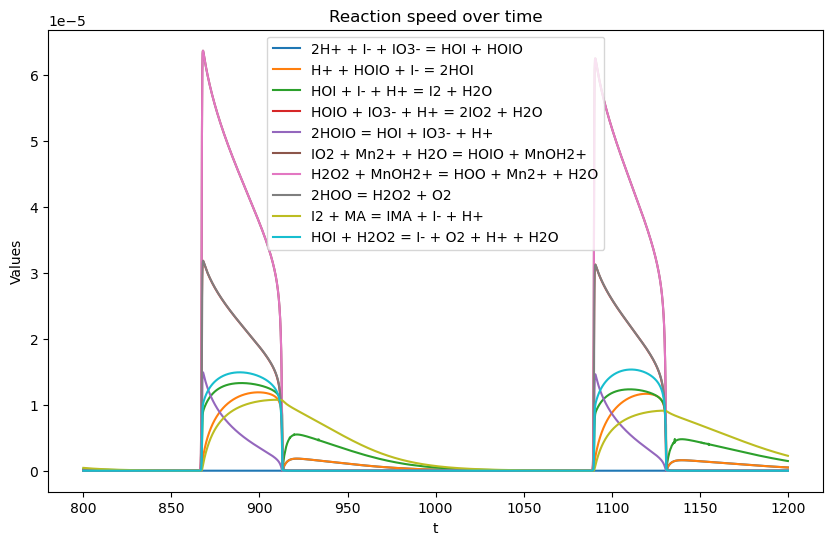

In [6]:
# Create checkboxes for each curve
reaction_checkboxes = [widgets.Checkbox(value=True, description=reaction_names[i]) for i in range(reaction_speed_curves.shape[0])]
r_button = widgets.Button(description="Plot Selected Reaction Speed Curves")

# Function to plot curves based on checkbox status
def plot_selected_reaction_speed_curves(b):
    start_time = 800 # 800-1200 to be an a period 0-2000 for total simulation intervalle
    end_time = 1200
    plt.figure(figsize=(10, 6))
    for i, cb in enumerate(reaction_checkboxes):
        if cb.value:  # If the checkbox is checked, plot the curve
            # Filter the data for the selected time window
            mask = (sol.t >= start_time) & (sol.t <= end_time)
            plt.plot(sol.t[mask], reaction_speed_curves[i][mask], label=reaction_names[i])
    plt.xlabel('t')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Reaction speed over time')
    plt.show()

# Bind the button click event to the plotting function
r_button.on_click(plot_selected_reaction_speed_curves)

# Display the checkboxes and the button
r_rows = [HBox(reaction_checkboxes[i:i+2]) for i in range(0, len(reaction_checkboxes), 2)]
display(VBox(r_rows + [r_button])) # comment this line for myBinder
plot_selected_reaction_speed_curves(0)

In [7]:
# Observations:
# Phase lente:
# Especes negligeables HOIO IO2 MnOH2+ (HOI, HOO)
# Consommation-production negligeable H2O2 O2
# Reactions synchronisées:
# 1 x r1 2H+ + I- + IO3- = HOI + HOIO
# 1 x r2 H+ + HOIO + I- = 2HOI
# 3 x r3 HOI + I- + H+ = I2 + H2O
# global synchro: 6H+ + 5I- + IO3- = 3I2 + 3H2O
# Autre reaction:
# >3 x r9 I2 + MA = IMA + I- + H+
# total phase lente: consommation I- I2 IO3- vers IMA

# Phase rapide:
# Especes negligeables I-
# Reactions synchronisées:
# 1 x r4 HOIO + IO3- + H+ = 2IO2 + H2O
# 2 x r6 IO2 + Mn2+ + H2O = HOIO + MnOH2+
# 2 x r7 H2O2 + MnOH2+ = HOO + Mn2+ + H2O
# 1 x r8 2HOO = H2O2 + O2
# global synchro: IO3- + H2O2 + H+ = HOIO + H2O + O2
# Autre reaction:
# En cloche:
# r2 H+ + HOIO + I- = 2HOI
# r3 HOI + I- + H+ = I2 + H2O
# r10 HOI + H2O2 = I- + O2 + H+ + H2O
# en sqrt
# r9 I2 + MA = IMA + I- + H+
# autre forme
# r5 2HOIO = HOI + I03- + H+   
# fin
